In [68]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masukumec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
# Data Loading

df = pd.read_csv(r"C:\Users\masukumec\Downloads\SMS Spam Collection Data.csv", encoding='latin-1', delimiter=';', on_bad_lines='skip')
# If the columns are named 'label' and 'message', map the labels
if 'label' in df.columns:
	df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print(df.head())

  Column1                                            Column2
0     ham  Go until jurong point, crazy.. Available only ...
1     ham                      Ok lar... Joking wif u oni...
2    spam  Free entry in 2 a wkly comp to win FA Cup fina...
3     ham  U dun say so early hor... U c already then say...
4     ham  Nah I don't think he goes to usf, he lives aro...


Column1
ham     4827
spam     747
Name: count, dtype: int64


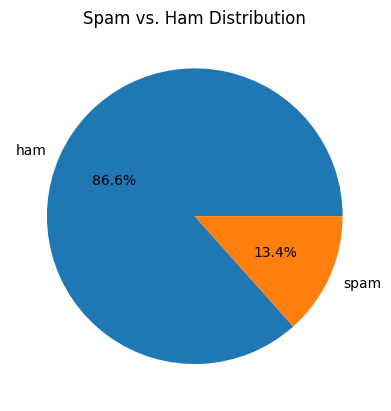

In [70]:
#Checking for class distribution

print(df['Column1'].value_counts())
plt.pie(df['Column1'].value_counts(), labels=['ham', 'spam'], autopct='%1.1f%%')
plt.title("Spam vs. Ham Distribution")
plt.show()

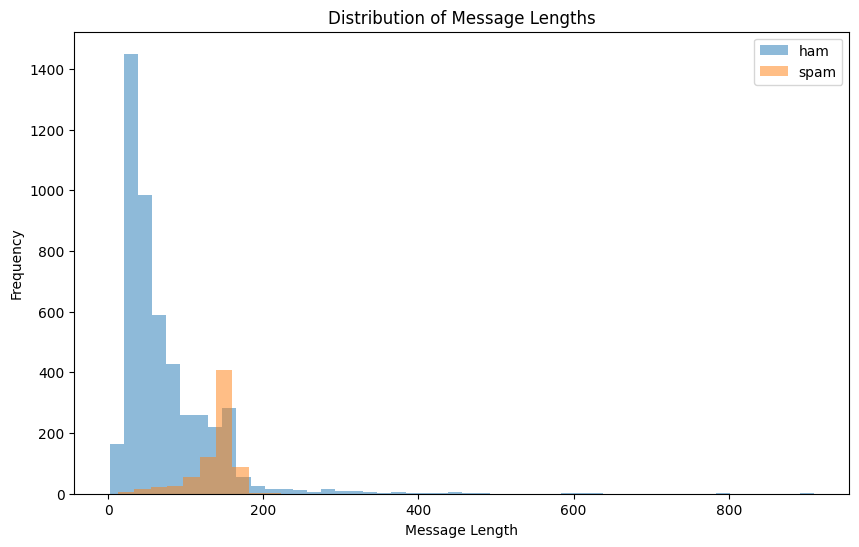

In [71]:
# Add a column for message length
df['length'] = df['Column2'].apply(len)

# Plot message length by class
plt.figure(figsize=(10, 6))
df[df['Column1'] == 'ham']['length'].plot(bins=50, kind='hist', alpha=0.5, label='ham')
df[df['Column1'] == 'spam']['length'].plot(kind='hist', alpha=0.5, label='spam')
plt.legend()
plt.xlabel("Message Length")
plt.title("Distribution of Message Lengths")
plt.show()


Label Distribution:
Column1
ham     4827
spam     747
Name: count, dtype: int64


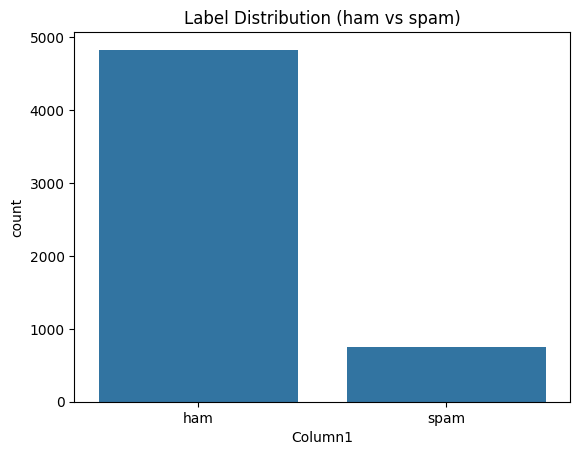

In [72]:
# EDA 
print("\nLabel Distribution:")
print(df['Column1'].value_counts())
sns.countplot(data=df, x='Column1')
plt.title('Label Distribution (ham vs spam)')
plt.show()

In [73]:
# Word Clouds (using original message column since 'cleaned_text' is not yet available)
ham_words = " ".join(df[df['Column1'] == 'ham']['Column2'])
spam_words = " ".join(df[df['Column1'] == 'spam']['Column2'])

(-0.5, 499.5, 299.5, -0.5)

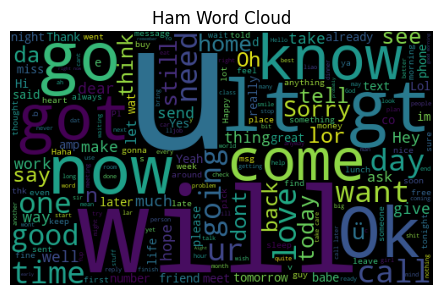

In [74]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=500, height=300).generate(ham_words))
plt.title("Ham Word Cloud")
plt.axis("off")

(-0.5, 499.5, 299.5, -0.5)

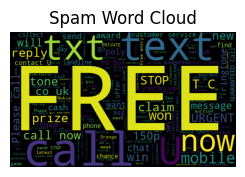

In [75]:
plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=500, height=300).generate(spam_words))
plt.title("Spam Word Cloud")
plt.axis("off")

In [76]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

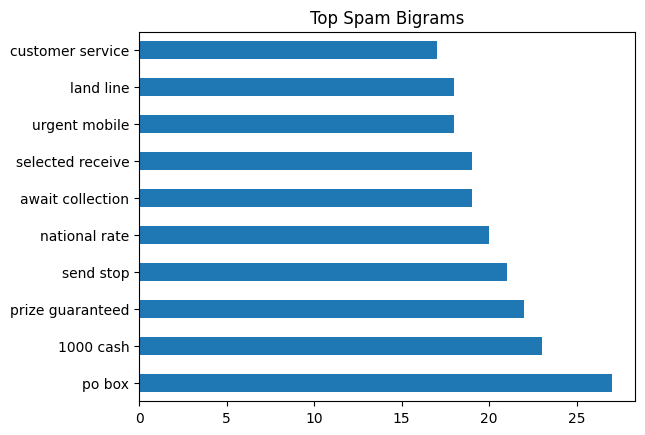

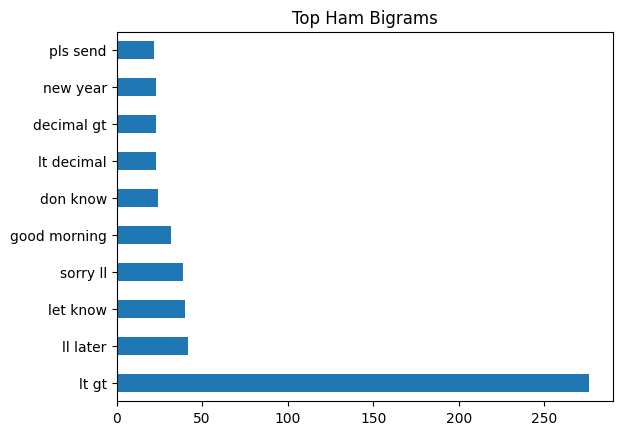

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

# Get top 10 bigrams for spam
spam_bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
spam_bigrams = spam_bigram_vectorizer.fit_transform(df[df['Column1'] == 'spam']['Column2'])
spam_bigram_counts = pd.DataFrame(
	spam_bigrams.toarray(), columns=spam_bigram_vectorizer.get_feature_names_out()
).sum().sort_values(ascending=False)[:10]

# Get top 10 bigrams for ham
ham_bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
ham_bigrams = ham_bigram_vectorizer.fit_transform(df[df['Column1'] == 'ham']['Column2'])
ham_bigram_counts = pd.DataFrame(
	ham_bigrams.toarray(), columns=ham_bigram_vectorizer.get_feature_names_out()
).sum().sort_values(ascending=False)[:10]

spam_bigram_counts.plot(kind='barh', title="Top Spam Bigrams")
plt.show()
ham_bigram_counts.plot(kind='barh', title="Top Ham Bigrams")
plt.show()

In [78]:
# Check for missing values
print(df.isnull().sum())

# Check for empty strings in the message column
print("Empty texts:", df[df['Column2'].str.strip() == ''].shape[0])

Column1    0
Column2    0
length     0
dtype: int64
Empty texts: 0


PreProcessing

In [79]:
# Ensure WordNetLemmatizer is available
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation/numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

# Apply to the dataset
df['cleaned_text'] = df['Column2'].apply(clean_text)
print(df[['Column2', 'cleaned_text']].head())

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\masukumec\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                             Column2  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                        cleaned_text  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4                nah think go usf life around though  


Feature Engineering

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=6284)  # Limit to top 6284 words
X = tfidf.fit_transform(df['cleaned_text'])
y = df['Column1'].map({'ham': 0, 'spam': 1})  # Binary labels

print(f"TF-IDF Shape: {X.shape}")  # (n_messages, n_features)

TF-IDF Shape: (5574, 6284)


In [81]:
# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['Column1'], test_size=0.2, random_state=42, stratify=df['Column1']
)

In [82]:
# --- Vectorization ---
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [83]:
from sklearn.model_selection import cross_val_score

# Convert string labels to binary
y_train_bin = y_train.map({'ham': 0, 'spam': 1})
y_test_bin = y_test.map({'ham': 0, 'spam': 1})

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(class_weight='balanced', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
}

for name, model in models.items():
    scores = cross_val_score(model, X_train_vec, y_train_bin, cv=5, scoring='f1')
    print(f"{name}: Mean F1 = {scores.mean():.3f} (±{scores.std():.3f})")

Logistic Regression: Mean F1 = 0.907 (±0.024)
Naive Bayes: Mean F1 = 0.857 (±0.018)
SVM: Mean F1 = 0.913 (±0.014)
Random Forest: Mean F1 = 0.902 (±0.023)


In [85]:
from sklearn.metrics import classification_report, confusion_matrix
results = []
for name, model in models.items():
    model.fit(X_train_vec, y_train_bin)
    y_pred = model.predict(X_test_vec)
    results.append({
        'Model': name,
        'Precision': precision_score(y_test_bin, y_pred, pos_label=1),  # Spam class
        'Recall': recall_score(y_test_bin, y_pred, pos_label=1),
        'F1-Score': f1_score(y_test_bin, y_pred, pos_label=1)
    })

df_results = pd.DataFrame(results)
print(df_results)

                 Model  Precision    Recall  F1-Score
0  Logistic Regression   0.932886  0.932886  0.932886
1          Naive Bayes   0.983051  0.778523  0.868914
2                  SVM   0.985507  0.912752  0.947735
3        Random Forest   1.000000  0.838926  0.912409


In [ ]:


# Convert string labels to binary
y_train_bin = y_train.map({'ham': 0, 'spam': 1})
y_test_bin = y_test.map({'ham': 0, 'spam': 1})

# Train model (with class weighting for imbalance)
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_vec, y_train_bin)

# Predict probabilities (for threshold tuning)
y_prob = model.predict_proba(X_test_vec)[:, 1]  # Probability of being spam

# Default threshold (0.5)
y_pred = (y_prob > 0.5).astype(int)
print(classification_report(y_test_bin, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.93      0.93      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10]  # Only valid for LogisticRegression
}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')
grid.fit(X_train_vec, y_train_bin)
print(f"Best params: {grid.best_params_}")

Best params: {'C': 10}


In [ ]:
# Risk level threshold

def adjust_risk_level(probabilities, threshold=0.5):
    return (probabilities > threshold).astype(int)

# Low-risk mode (threshold = 0.9)
y_pred_low_risk = adjust_risk_level(y_prob, threshold=0.9)
print("Low-Risk (Restrictive):\n", classification_report(y_test_bin, y_pred_low_risk))

# High-risk mode (threshold = 0.3)
y_pred_high_risk = adjust_risk_level(y_prob, threshold=0.3)
print("High-Risk (Lenient):\n", classification_report(y_test_bin, y_pred_high_risk))

Low-Risk (Restrictive):
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       966
           1       1.00      0.62      0.77       149

    accuracy                           0.95      1115
   macro avg       0.97      0.81      0.87      1115
weighted avg       0.95      0.95      0.94      1115

High-Risk (Lenient):
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       966
           1       0.73      0.96      0.83       149

    accuracy                           0.95      1115
   macro avg       0.86      0.95      0.90      1115
weighted avg       0.96      0.95      0.95      1115



In [ ]:
# --- Evaluation ---
preds = model.predict(X_test_vec)
print("\nClassification Report:")
print(classification_report(y_test_bin, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.93      0.93      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



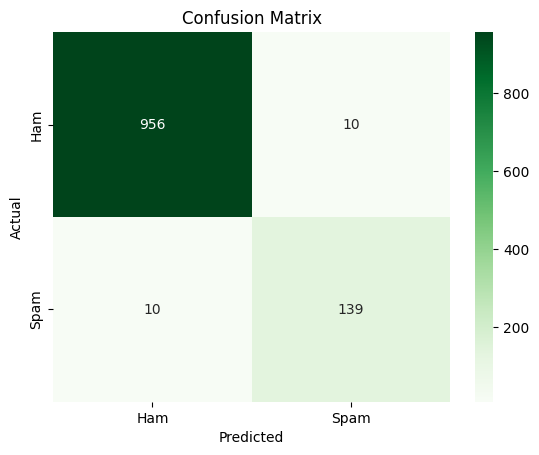

In [ ]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test_bin, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import joblib

joblib.dump(model, 'spam_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [ ]:
import os

# Ensure the directory exists before saving
os.makedirs('data', exist_ok=True)
df.to_csv('data/cleaned_spam_dataset.csv', index=False)